## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
import os

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: define the Net in models.py

import torch
import torch.nn as nn

## TODO: once you've define the network, you can instantiate it

# one example conv layer has been provided for you
from models import Net, initialize_xavier, count_parameters

# random seed PyTorch and Numpy
torch.manual_seed(42)
np.random.seed(42)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

# create the network
net = Net()

# initialize the network parameters
net.apply(initialize_xavier)

# display the network architecture
print(net)
print('Trainable parameters: {}'.format(count_parameters(net)))

Net(
  (extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

## Transform the dataset

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

## TODO: define the data_transform using transforms.Compose([all tx's, . , .])

# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(256), RandomCrop(224), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file=os.path.join('.', 'data', 'training_frames_keypoints.csv'),
                                             root_dir=os.path.join('.', 'data', 'training', ''),
                                             transform=data_transform)

print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
train_batch_size = 64
train_loader = DataLoader(transformed_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file=os.path.join('.', 'data', 'test_frames_keypoints.csv'),
                                      root_dir=os.path.join('.', 'data', 'test', ''),
                                      transform=data_transform)

In [7]:
# load test data in batches
test_batch_size = 10
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
def net_sample_output(model, test_loader):
    """
    Tests a model on a batch of test images

    Parameters
    ----------
    model : torch.nn.Module
        The model
    test_loader : torch.utils.data.DataLoader
        The images data loader

    Returns
    -------
    torch.Tensor
        The images of the first batch
    torch.Tensor
        The predicted keypoints of the first batch
    torch.Tensor
        The ground-truth keypoints of the first batch
    """

    model.cpu()
    model.eval()

    with torch.no_grad():

        # iterate through the test dataset
        for i, sample in enumerate(test_loader):

            # get sample data: images and ground truth keypoints
            images = sample['image']
            key_pts = sample['keypoints']

            # convert images to FloatTensors
            images = images.type(torch.FloatTensor)

            # forward pass to get net output
            output_pts = model(images)

            # reshape to batch_size x 68 x 2 pts
            output_pts = output_pts.view(output_pts.size()[0], 68, -1)

            # break after first batch is tested
            if i == 0:
                return images, output_pts, key_pts

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, pd_pts, gt_pts=None):
    """
    Displays an image with its predicted and ground-truth facial landmarks

    Parameters
    ----------
    image : numpy.ndarray
        The image
    pd_pts : numpy.ndarray
        The predicted keypoints
    gt_pts : numpy.ndarray
        The ground-truth keypoints
    """

    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(pd_pts[:, 0], pd_pts[:, 1], s=20, marker='.', c='m')

    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

In [11]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    """
    Displays predicted and ground-truth facial landmarks of a test batch

    Parameters
    ----------
    test_images : torch.Tensor
        The images of a test batch
    test_outputs : torch.Tensor
        The predicted keypoints for each test image
    gt_pts : torch.Tensor
        The ground-truth keypoints for each test image
    batch_size : int
        The size of the test batch to display
    """

    fig = plt.figure(figsize=(22, 8))

    for i in range(batch_size):

        fig.add_subplot(batch_size/5, 5, i+1, xticks=[], yticks=[])

        # un-transform the image data
        image = test_images[i].data             # get the image from it's wrapper
        image = image.cpu().numpy()             # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))  # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data

        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts.cpu().numpy(), ground_truth_pts.cpu().numpy())

    plt.axis('off')
    plt.show()

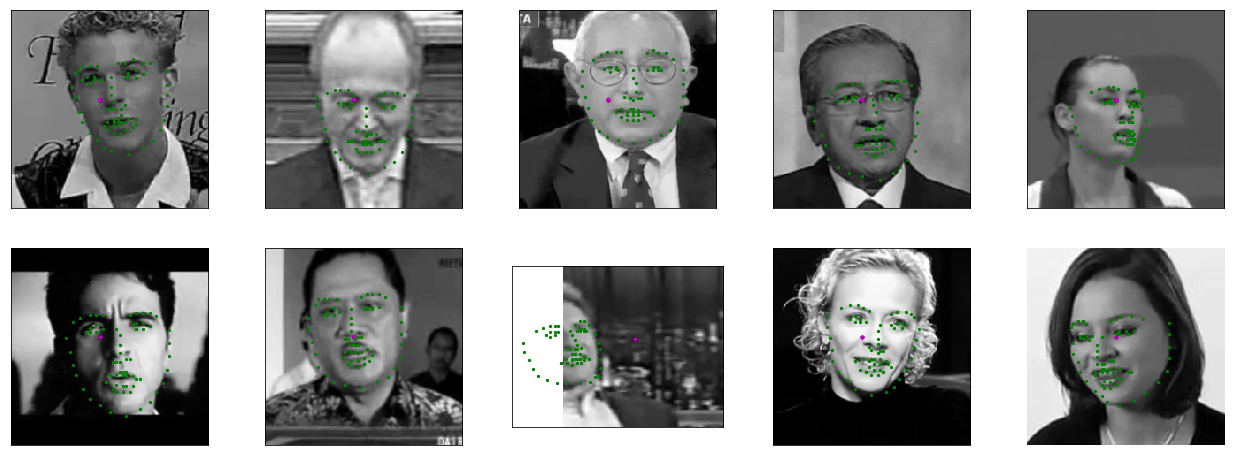

In [12]:
# visualize the output
# by default this shows a batch of 10 images
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: define the loss and optimization

import torch.optim as optim

criterion = nn.SmoothL1Loss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.1)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs.

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc.

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs, model, criterion, optimizer, train_loader, device):
    """
    Trains a PyTorch model to predict facial landmarks

    Parameters
    ----------
    n_epochs : int
        The number of epochs used to train the model
    model : torch.nn.Module
        The PyTorch model to train
    criterion : torch.nn.Criterion
        The approach to measure the model loss during training
    optimizer : torch.optim.Optimizer
        The approach to optimize the model parameters
    train_loader : torch.utils.data.DataLoader
        The images data loader
    device : torch.device
        'cuda:x' uses CUDA implementation with GPU:x
        'cpu'    uses CPU implementation

    Returns
    -------
    numpy.ndarray
        The average loss of each train batch for every epoch
    """

    # move model to GPU if CUDA implementation is selected
    model = model.to(device)

    # prepare the net for training
    model.train()

    # loop over the dataset multiple times
    batch_loss = torch.zeros((n_epochs, len(train_loader)))
    for epoch in range(n_epochs):

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):

            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # move tensors to GPU if CUDA is available
            images, key_pts = images.to(device), key_pts.to(device)

            # forward pass to get outputs
            output_pts = model(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            batch_loss[epoch, batch_i] = loss.item()
            if batch_i % 10 == 9:  # print every 10 batches
                avg_loss = torch.mean(batch_loss[epoch, batch_i:batch_i+10])
                print('Epoch: {}, Batch: {}, Avg. Loss: {:0.4f}'.format(epoch+1, batch_i+1, avg_loss))

    print('Finished Training')

    return batch_loss.cpu().numpy().flatten()

In [15]:
# train your network
# start small, and increase when you've decided on your model structure and hyperparams
n_epochs = 200
train_losses = train_net(n_epochs, net, criterion, optimizer, train_loader, device)

Epoch: 1, Batch: 10, Avg. Loss: 201.2732
Epoch: 1, Batch: 20, Avg. Loss: 127.3098
Epoch: 1, Batch: 30, Avg. Loss: 106.3605
Epoch: 1, Batch: 40, Avg. Loss: 91.3151
Epoch: 1, Batch: 50, Avg. Loss: 151.6102
Epoch: 2, Batch: 10, Avg. Loss: 64.6228
Epoch: 2, Batch: 20, Avg. Loss: 48.6358
Epoch: 2, Batch: 30, Avg. Loss: 61.7973
Epoch: 2, Batch: 40, Avg. Loss: 68.2482
Epoch: 2, Batch: 50, Avg. Loss: 119.1494
Epoch: 3, Batch: 10, Avg. Loss: 51.3630
Epoch: 3, Batch: 20, Avg. Loss: 54.3376
Epoch: 3, Batch: 30, Avg. Loss: 51.2150
Epoch: 3, Batch: 40, Avg. Loss: 50.6192
Epoch: 3, Batch: 50, Avg. Loss: 113.0423
Epoch: 4, Batch: 10, Avg. Loss: 47.3919
Epoch: 4, Batch: 20, Avg. Loss: 49.5944
Epoch: 4, Batch: 30, Avg. Loss: 45.4276
Epoch: 4, Batch: 40, Avg. Loss: 49.5431
Epoch: 4, Batch: 50, Avg. Loss: 104.5700
Epoch: 5, Batch: 10, Avg. Loss: 44.5481
Epoch: 5, Batch: 20, Avg. Loss: 48.8797
Epoch: 5, Batch: 30, Avg. Loss: 41.7977
Epoch: 5, Batch: 40, Avg. Loss: 50.5814
Epoch: 5, Batch: 50, Avg. Loss: 6

Epoch: 41, Batch: 30, Avg. Loss: 5.9761
Epoch: 41, Batch: 40, Avg. Loss: 25.3548
Epoch: 41, Batch: 50, Avg. Loss: 11.1703
Epoch: 42, Batch: 10, Avg. Loss: 8.2330
Epoch: 42, Batch: 20, Avg. Loss: 5.4519
Epoch: 42, Batch: 30, Avg. Loss: 17.8537
Epoch: 42, Batch: 40, Avg. Loss: 10.7977
Epoch: 42, Batch: 50, Avg. Loss: 9.4662
Epoch: 43, Batch: 10, Avg. Loss: 23.2787
Epoch: 43, Batch: 20, Avg. Loss: 11.4487
Epoch: 43, Batch: 30, Avg. Loss: 7.5072
Epoch: 43, Batch: 40, Avg. Loss: 5.6804
Epoch: 43, Batch: 50, Avg. Loss: 9.2211
Epoch: 44, Batch: 10, Avg. Loss: 6.0434
Epoch: 44, Batch: 20, Avg. Loss: 8.4937
Epoch: 44, Batch: 30, Avg. Loss: 25.1789
Epoch: 44, Batch: 40, Avg. Loss: 6.6800
Epoch: 44, Batch: 50, Avg. Loss: 10.9203
Epoch: 45, Batch: 10, Avg. Loss: 7.3359
Epoch: 45, Batch: 20, Avg. Loss: 4.3810
Epoch: 45, Batch: 30, Avg. Loss: 16.1151
Epoch: 45, Batch: 40, Avg. Loss: 6.5798
Epoch: 45, Batch: 50, Avg. Loss: 15.2504
Epoch: 46, Batch: 10, Avg. Loss: 6.7031
Epoch: 46, Batch: 20, Avg. Los

Epoch: 82, Batch: 20, Avg. Loss: 6.7766
Epoch: 82, Batch: 30, Avg. Loss: 5.6650
Epoch: 82, Batch: 40, Avg. Loss: 4.1130
Epoch: 82, Batch: 50, Avg. Loss: 22.8375
Epoch: 83, Batch: 10, Avg. Loss: 4.0233
Epoch: 83, Batch: 20, Avg. Loss: 3.7295
Epoch: 83, Batch: 30, Avg. Loss: 5.2654
Epoch: 83, Batch: 40, Avg. Loss: 4.8030
Epoch: 83, Batch: 50, Avg. Loss: 8.6384
Epoch: 84, Batch: 10, Avg. Loss: 10.3384
Epoch: 84, Batch: 20, Avg. Loss: 13.4675
Epoch: 84, Batch: 30, Avg. Loss: 17.3189
Epoch: 84, Batch: 40, Avg. Loss: 10.8700
Epoch: 84, Batch: 50, Avg. Loss: 5.9678
Epoch: 85, Batch: 10, Avg. Loss: 10.3971
Epoch: 85, Batch: 20, Avg. Loss: 4.4284
Epoch: 85, Batch: 30, Avg. Loss: 4.9482
Epoch: 85, Batch: 40, Avg. Loss: 3.8310
Epoch: 85, Batch: 50, Avg. Loss: 6.7387
Epoch: 86, Batch: 10, Avg. Loss: 5.4757
Epoch: 86, Batch: 20, Avg. Loss: 3.2950
Epoch: 86, Batch: 30, Avg. Loss: 11.4305
Epoch: 86, Batch: 40, Avg. Loss: 9.3324
Epoch: 86, Batch: 50, Avg. Loss: 6.4703
Epoch: 87, Batch: 10, Avg. Loss: 

Epoch: 122, Batch: 40, Avg. Loss: 23.4414
Epoch: 122, Batch: 50, Avg. Loss: 7.7050
Epoch: 123, Batch: 10, Avg. Loss: 4.2267
Epoch: 123, Batch: 20, Avg. Loss: 4.3134
Epoch: 123, Batch: 30, Avg. Loss: 3.6480
Epoch: 123, Batch: 40, Avg. Loss: 4.1078
Epoch: 123, Batch: 50, Avg. Loss: 11.8757
Epoch: 124, Batch: 10, Avg. Loss: 4.3588
Epoch: 124, Batch: 20, Avg. Loss: 4.1069
Epoch: 124, Batch: 30, Avg. Loss: 4.2382
Epoch: 124, Batch: 40, Avg. Loss: 3.9212
Epoch: 124, Batch: 50, Avg. Loss: 19.4985
Epoch: 125, Batch: 10, Avg. Loss: 7.8694
Epoch: 125, Batch: 20, Avg. Loss: 3.3193
Epoch: 125, Batch: 30, Avg. Loss: 8.1131
Epoch: 125, Batch: 40, Avg. Loss: 22.4393
Epoch: 125, Batch: 50, Avg. Loss: 5.8465
Epoch: 126, Batch: 10, Avg. Loss: 3.1789
Epoch: 126, Batch: 20, Avg. Loss: 5.4935
Epoch: 126, Batch: 30, Avg. Loss: 3.4847
Epoch: 126, Batch: 40, Avg. Loss: 5.2439
Epoch: 126, Batch: 50, Avg. Loss: 5.9310
Epoch: 127, Batch: 10, Avg. Loss: 3.4876
Epoch: 127, Batch: 20, Avg. Loss: 33.5760
Epoch: 127,

Epoch: 162, Batch: 40, Avg. Loss: 4.4704
Epoch: 162, Batch: 50, Avg. Loss: 5.5768
Epoch: 163, Batch: 10, Avg. Loss: 3.0057
Epoch: 163, Batch: 20, Avg. Loss: 4.2440
Epoch: 163, Batch: 30, Avg. Loss: 3.4252
Epoch: 163, Batch: 40, Avg. Loss: 5.0838
Epoch: 163, Batch: 50, Avg. Loss: 6.3903
Epoch: 164, Batch: 10, Avg. Loss: 3.4642
Epoch: 164, Batch: 20, Avg. Loss: 5.5261
Epoch: 164, Batch: 30, Avg. Loss: 3.9795
Epoch: 164, Batch: 40, Avg. Loss: 3.6628
Epoch: 164, Batch: 50, Avg. Loss: 6.5550
Epoch: 165, Batch: 10, Avg. Loss: 7.8421
Epoch: 165, Batch: 20, Avg. Loss: 2.9890
Epoch: 165, Batch: 30, Avg. Loss: 2.8178
Epoch: 165, Batch: 40, Avg. Loss: 4.0822
Epoch: 165, Batch: 50, Avg. Loss: 7.6787
Epoch: 166, Batch: 10, Avg. Loss: 3.6694
Epoch: 166, Batch: 20, Avg. Loss: 3.5888
Epoch: 166, Batch: 30, Avg. Loss: 4.9589
Epoch: 166, Batch: 40, Avg. Loss: 5.4733
Epoch: 166, Batch: 50, Avg. Loss: 4.5658
Epoch: 167, Batch: 10, Avg. Loss: 4.3966
Epoch: 167, Batch: 20, Avg. Loss: 6.4497
Epoch: 167, Batc

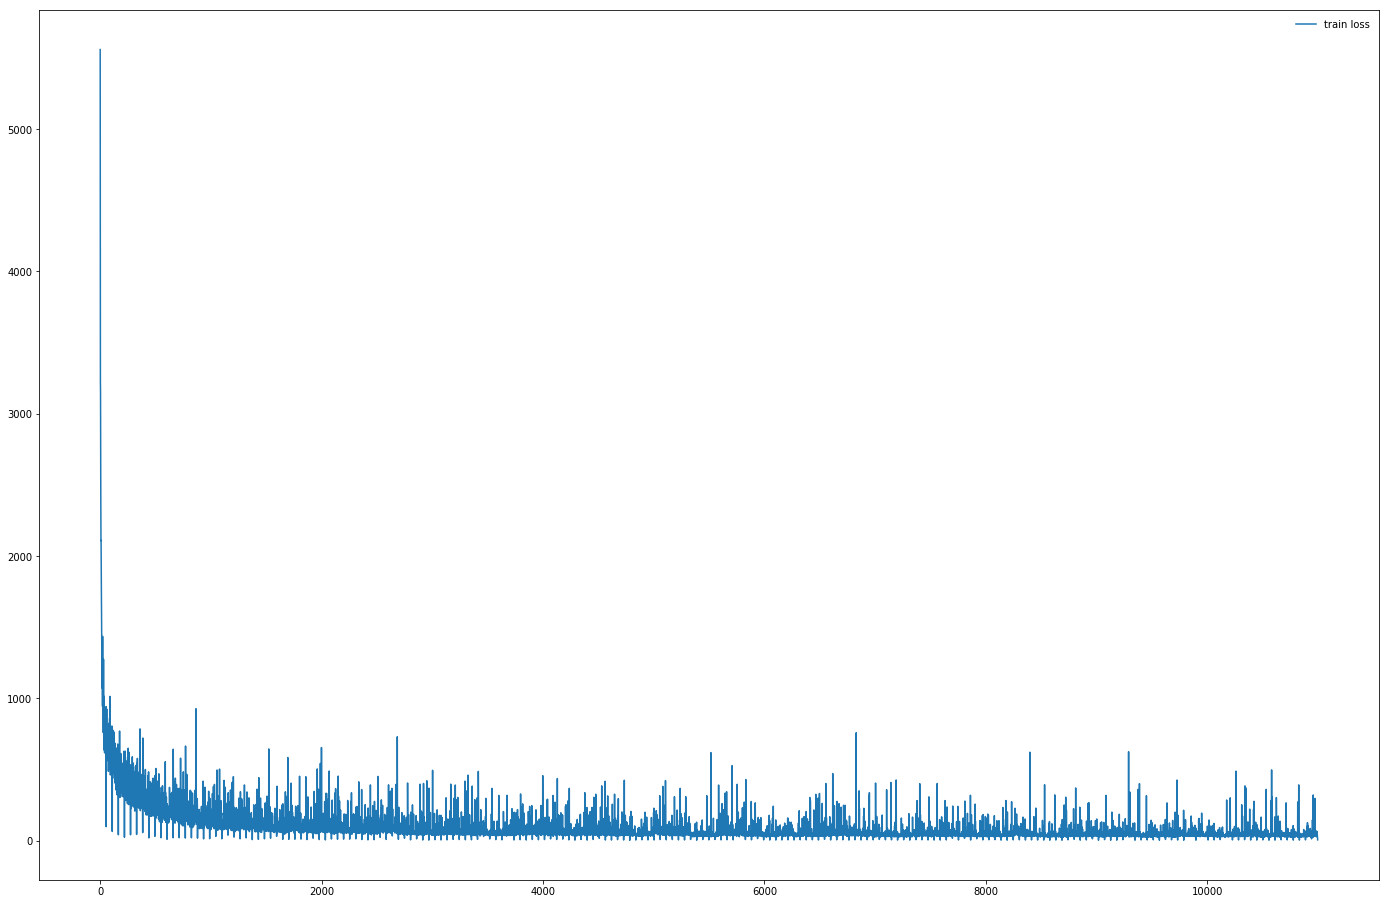

In [16]:
# plot the batch train loss
plt.figure(figsize=(24, 16))
plt.plot(train_losses, label='train loss')
plt.legend(frameon=False)

In [17]:
def save_net(model, filename):
    """
    Saves the parameter dictionary of a PyTorch model

    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to save
    filename : str
        The filename of the model's parameter dictionary
    """

    torch.save(model.state_dict(), filename)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [18]:
## TODO: change the name to something uniqe for each new model

model_dir = os.path.join('.', 'models')
model_name = 'keypoints_model_e{}_b{}.pt'.format(n_epochs, train_batch_size)

# after training, save your model parameters in the dir 'models'
save_net(net, os.path.join(model_dir, model_name))

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [19]:
def test_net(model, test_loader, criterion, device):
    """
    Tests a PyTorch model that predicts facial landmarks

    model : torch.nn.Module
        The PyTorch model to test
    train_loader : torch.utils.data.DataLoader
        The images data loader
    criterion : torch.nn.Criterion
        The approach to measure the model loss during test
    device : torch.device
        'cuda:x' uses CUDA implementation with GPU:x
        'cpu'    uses CPU implementation

    Returns
    -------
    numpy.ndarray
        The average loss of each test batch
    """

    # move model to GPU if CUDA implementation is selected
    model = model.to(device)

    # prepare the net for testing
    model.eval()

    # do not calculate gradients
    with torch.no_grad():

        # test on batches of data, assumes you already have test_loader
        batch_loss = torch.zeros((len(test_loader)))
        for batch_i, data in enumerate(test_loader):

            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten keypoints
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # move tensors to GPU if CUDA is available
            images, key_pts = images.to(device), key_pts.to(device)

            # forward pass to get outputs
            output_pts = model(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # store loss statistics
            batch_loss[batch_i] = loss.item()

    print('Avg. Loss: {:0.4f}'.format(torch.mean(batch_loss)))
    print('Finished Testing')

    return batch_loss.cpu().numpy()

In [20]:
def benchmark_net(model, device, rounds=1000):
    """
    Benchmarks a PyTorch model that predicts facial landmarks

    model : torch.nn.Module
        The PyTorch model to benchmark
    device : torch.device
        'cuda:x' uses CUDA implementation with GPU:x
        'cpu'    uses CPU implementation
    rounds : int
        The number of independent run-time measures

    Returns
    -------
    float
        The average run-time in milliseconds
    """

    # prepare data to benchmark
    data = torch.randn((1, 1, 224, 224), dtype=torch.float).to(device)

    # prepare the net for benchmarking
    model.eval()
    model = model.to(device)

    # do not calculate gradients
    with torch.no_grad():

        # benchmark rounds
        times = torch.zeros(rounds)
        for index in torch.arange(rounds):
            times[index] -= timeit.default_timer()
            model(data)
            times[index] += timeit.default_timer()

        # measure run-time in milliseconds
        times *= 1000.0

    # calculate average run-time
    mean_time = times.mean()

    # get device name with gpu option
    if device.type == 'cuda':
        device_name = torch.cuda.get_device_name(0)

    # get device name with cpu option
    else:
        device_name = '{} with {} threads'.format(device, torch.get_num_threads())

    # display results
    print('Avg. Run-time: {:0.4f}\tDevice: {}'.format(mean_time, device_name))
    print('Finished Benchmarking')

    # return average run-time
    return mean_time

In [21]:
def load_net(model, filename):
    """
    Loads a parameter dictionary into a PyTorch model

    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to restore
    filename : str
        The filename of the model's parameter dictionary
    """

    state_dict = torch.load(filename)
    model.load_state_dict(state_dict)

In [22]:
import timeit

# get your networks and create an array for their test losses
networks = [f for f in os.listdir(model_dir) if f.endswith('.pt')]
results = np.zeros((len(networks), len(test_loader)))

# test your networks
min_loss = np.inf
best_model = None
for idx, f in enumerate(networks):

    # restore trained network
    net = Net()
    load_net(net, os.path.join(model_dir, f))

    # test trained network
    print('Evaluate {}'.format(f[:-3]))
    results[idx] = test_net(net, test_loader, criterion, device)
    benchmark_net(net, device)

    # look for the lowest average test loss
    avg_loss = results[idx].mean()
    if avg_loss < min_loss:
        best_model = f
        min_loss = avg_loss
        save_net(net, os.path.join(model_dir, 'keypoints_model_deploy.pt'))

# display the best model
print('Best model: {}'.format(best_model[:-3]))

# load the best model
load_net(net, os.path.join(model_dir, best_model))

Evaluate keypoints_model_e100_b16
Avg. Loss: 12.3677
Finished Testing
Avg. Run-time: 1.9940	Device: Quadro P2000
Finished Benchmarking
Evaluate keypoints_model_e100_b32
Avg. Loss: 10.0983
Finished Testing
Avg. Run-time: 1.9324	Device: Quadro P2000
Finished Benchmarking
Evaluate keypoints_model_e100_b64
Avg. Loss: 13.7750
Finished Testing
Avg. Run-time: 1.9228	Device: Quadro P2000
Finished Benchmarking
Evaluate keypoints_model_e200_b16
Avg. Loss: 8.3794
Finished Testing
Avg. Run-time: 1.9758	Device: Quadro P2000
Finished Benchmarking
Evaluate keypoints_model_e200_b32
Avg. Loss: 8.6037
Finished Testing
Avg. Run-time: 1.9453	Device: Quadro P2000
Finished Benchmarking
Evaluate keypoints_model_e200_b64
Avg. Loss: 5.4859
Finished Testing
Avg. Run-time: 1.9329	Device: Quadro P2000
Finished Benchmarking
Evaluate keypoints_model_e25_b16
Avg. Loss: 16.2591
Finished Testing
Avg. Run-time: 1.9154	Device: Quadro P2000
Finished Benchmarking
Evaluate keypoints_model_e25_b32
Avg. Loss: 17.7306
Finishe

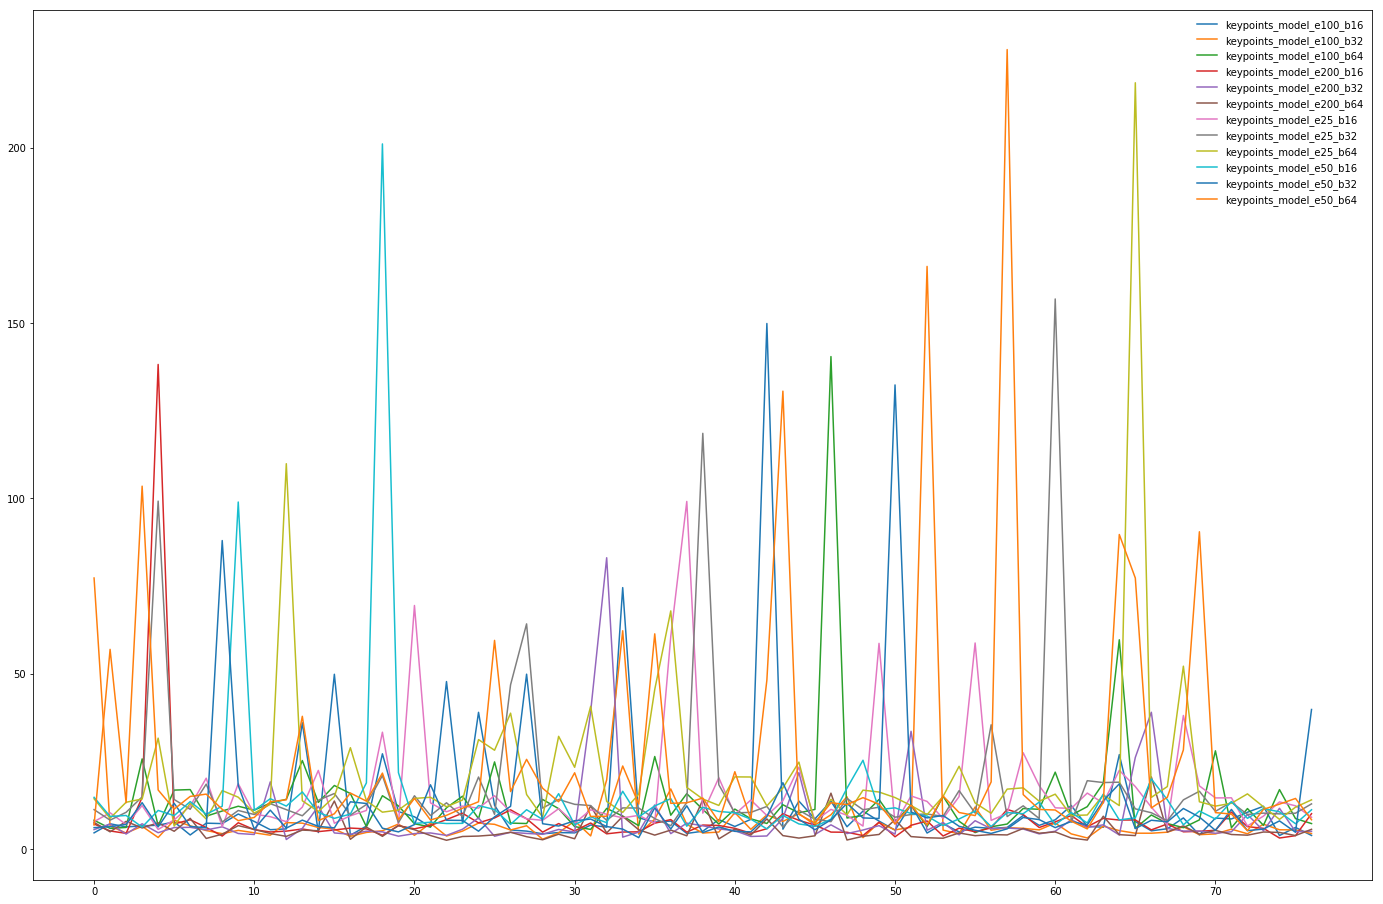

In [23]:
# plot the batch test loss
plt.figure(figsize=(24, 16))

for idx, f in enumerate(networks):
    plt.plot(results[idx], label=f[:-3])
    plt.legend(frameon=False)

In [24]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


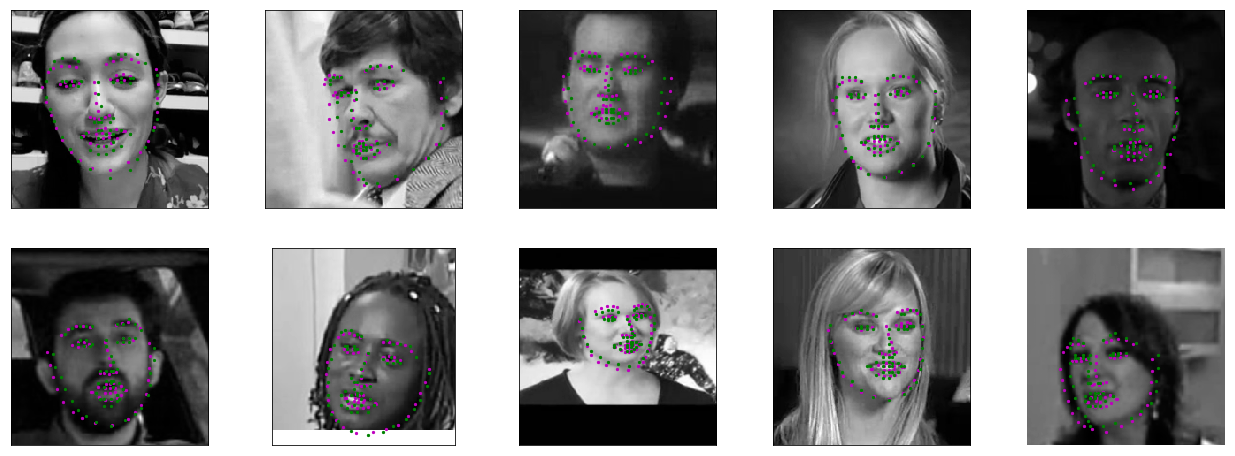

In [25]:
## TODO: visualize your test output

# you can use the same function as before, by un-commenting the line below:
visualize_output(test_images, test_outputs, gt_pts)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: The neural network is trained to minimize the [Huber Loss](http://pytorch.org/docs/stable/nn.html#torch.nn.SmoothL1Loss) based on the analysis of multiple loss functions introduced by [Grover 2018](http://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0).

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: The proposed architecture combines seven convolutional blocks to extract visual features from an input image (i.e., feature extractor) and then feeds them to one fully connected layer to regress the facial landmarks (i.e., keypoint regressor) in-line with reference architecture from [Agarwal et al. 2017](http://arxiv.org/abs/1710.00977). Motivated by the reduction of run-time latency, the feature extractor blocks use a single strided convolution, as suggested by [Bojja et al. 2017](http://arxiv.org/abs/1711.05944), instead of combining convolution and max pool layers. Furthermore, it decouples the feature extractor blocks from one another by introducing batch normalization layers before non-linear activations, thus, reducing convergence times and introducing a slight regularization during learning. It also uses a combination of one 5 and 1 kernel sizes at the I/O blocks, while keeping a kernel size of 3 in all the internal blocks of the feature extractor. Finally, it considerably reduces the number of parameters by employing a single fully connected layer in the keypoint regressor. The qualitative results from the complete pipeline show that models with the proposed architecture can estimate facial landmarks accurately with roughly 10x less the number of parameters than models with the reference architecture. Further research and development should focus on replacing the keypoint regressor with a [fully convolutional network](http://arxiv.org/abs/1411.4038), and reducing the model footprint using [depthwise separable convolutions](http://arxiv.org/abs/1610.02357).

In [26]:
from torchsummary import summary

net = net.to(device)
summary(net, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             200
       BatchNorm2d-2          [-1, 8, 112, 112]              16
              ReLU-3          [-1, 8, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]           1,152
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
            Conv2d-7           [-1, 32, 28, 28]           4,608
       BatchNorm2d-8           [-1, 32, 28, 28]              64
              ReLU-9           [-1, 32, 28, 28]               0
           Conv2d-10           [-1, 64, 14, 14]          18,432
      BatchNorm2d-11           [-1, 64, 14, 14]             128
             ReLU-12           [-1, 64, 14, 14]               0
           Conv2d-13            [-1, 128, 7, 7]          73,728
      BatchNorm2d-14            [-1, 12

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: The number of epochs and batch size are determined using a [grid search](http://www.sciencedirect.com/topics/mathematics/grid-search) with twelve configurations. The evaluated batch sizes are ```[16, 32, 64]``` and epochs are ```[25, 50, 100, 200]```. The combination of values that leads to the model with the minimum average test loss is selected for deployment.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 1.30414248e-01  1.30391002e-01  7.08853826e-02 -1.18745156e-01
  -4.66404520e-02]
 [ 1.16481431e-01 -1.16351590e-01  4.88326363e-02 -3.66067849e-02
  -2.25168318e-01]
 [ 1.26019880e-01 -9.91201159e-05  4.13774848e-02 -7.16352761e-02
  -3.96428257e-02]
 [ 2.15146095e-01  1.00169398e-01 -5.22912517e-02 -1.33424968e-01
   4.92270291e-03]
 [ 2.20267221e-01 -3.66266035e-02 -9.37841609e-02 -6.17563166e-02
  -1.87982142e-01]]
(5, 5)
[[ 0.15393631  0.08595224 -0.04097446 -0.07442428 -0.1494354 ]
 [ 0.033647    0.03308051  0.01186006 -0.06625059 -0.19389397]
 [ 0.23727413  0.14773935 -0.0101634  -0.12610182 -0.14122026]
 [ 0.09275997  0.07635796  0.05387896  0.1587989   0.02404549]
 [ 0.04650418  0.0811453  -0.10920405  0.03393524  0.10497316]]
(5, 5)
[[-0.1725699  -0.06607317 -0.26550916 -0.15565096  0.01646427]
 [-0.05247775 -0.20407252 -0.24923712  0.02363568 -0.08743764]
 [-0.03473901 -0.11383787 -0.12171753  0.07865213  0.21695086]
 [ 0.1907708  -0.01252013  0.0383624   0.02935307  0.00

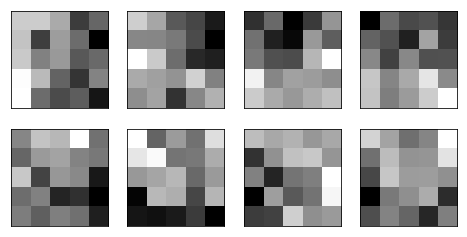

In [27]:
# get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.extractor[0].weight.data

w = weights1.cpu().numpy()
fig = plt.figure(figsize=(8, 4))

for filter_index, _ in enumerate(w):

    print(w[filter_index][0])
    print(w[filter_index][0].shape)

    # display the filter weights
    fig.add_subplot(2, 4, filter_index+1, xticks=[], yticks=[])
    plt.imshow(w[filter_index][0], cmap='gray')

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

(<matplotlib.image.AxesImage at 0x18d93dbe470>, Text(0.5, 1.0, 'Filtered'))

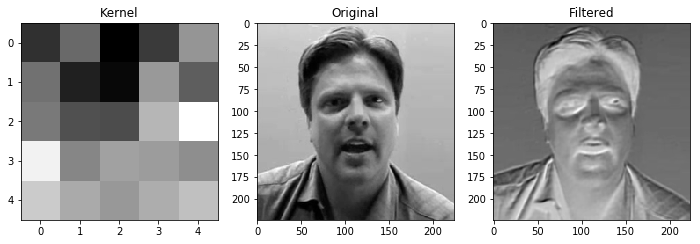

In [28]:
## TODO: load in and display any image from the transformed test dataset

import cv2

image_index = np.random.randint(0, len(test_dataset))
image_sample = np.squeeze(test_dataset[image_index]['image'].numpy())

## TODO: using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

filter_index = np.random.randint(0, len(w))
filter_sample = np.squeeze(w[filter_index])

image_filtered = cv2.filter2D(image_sample, -1, filter_sample)

fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 3, 1)
plt.imshow(filter_sample, cmap='gray'), plt.title('Kernel')
fig.add_subplot(1, 3, 2)
plt.imshow(image_sample, cmap='gray'), plt.title('Original')
fig.add_subplot(1, 3, 3)
plt.imshow(image_filtered, cmap='gray'), plt.title('Filtered')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The filter seems to detect curved edges between lighter and darker pixels (e.g., around edges from the hair, mouth lips, or eyes).

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!